DVF chargé
Calcul des features spatiales...
MAE (Mean Absolute Error) - Test : 233751.82
MAE (Mean Absolute Error) - Train : 92363.25
MAE Test as % of mean valeur_fonciere : 42.90%
R² score : 0.6904

🔎 MAE par type de local :
Type: Local industriel. commercial ou assimilé | MAE: 946,352.94 € | N = 112
Type: Dépendance           | MAE: 198,387.99 € | N = 1778
Type: Maison               | MAE: 169,362.35 € | N = 263


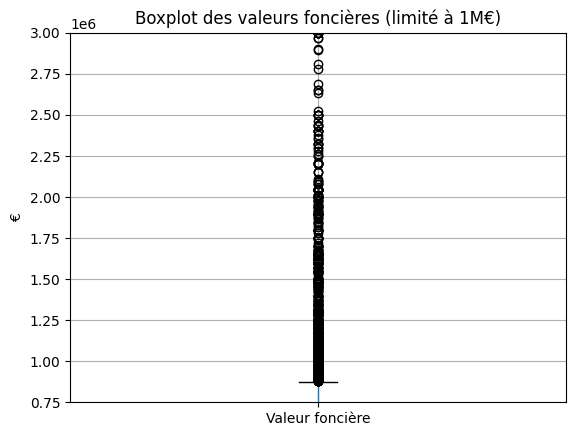

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree
import networkx as nx
from geopy.distance import geodesic
from collections import defaultdict

# 🔧 Coordonnées du centre de Bordeaux
lat_center = 44.833328
lon_center = -0.56667

# 🔧 Fonction utilitaire pour BallTree
def count_neighbors(tree, points, radius_m):
    radius = radius_m / 6371000
    counts = tree.query_radius(points, r=radius, count_only=True)
    return counts

# =====================================
# 📝 1. Charger les données immobilières
# =====================================
df = pd.read_csv("./db/Bordeaux.csv", sep=";", encoding="utf-8", skiprows=lambda i: i > 0 and np.random.rand() > 1)
print("DVF chargé")

# Nettoyer lat/lon
df = df.dropna(subset=["Valeur foncière", "Latitude", "Longitude"]).reset_index(drop=True)
df['lat_rad'] = np.deg2rad(df['Latitude'])
df['lon_rad'] = np.deg2rad(df['Longitude'])
logements_coords = df[['lat_rad', 'lon_rad']].to_numpy()

# =====================================
# 📝 2. Charger commerces et écoles
# =====================================
commerces = pd.read_csv("./db/entreprise_bordeaux.csv", sep=";", encoding="utf-8", skiprows=lambda i: i > 0 and np.random.rand() > 0.1)
ecoles = pd.read_csv("./db/educ_bordeaux.csv", sep=";", encoding="utf-8", skiprows=lambda i: i > 0 and np.random.rand() > 0.1)

# Nettoyer Geo Point commerces
if 'Geo Point' in commerces.columns:
    geo_split = commerces['Geo Point'].str.extract(r'([0-9\.\-]+),\s*([0-9\.\-]+)')
    commerces['latitude'] = geo_split[0].astype(float)
    commerces['longitude'] = geo_split[1].astype(float)
else:
    raise KeyError("Geo Point manquant dans commerces")

# Convertir en radians
for df_tmp in [commerces, ecoles]:
    df_tmp['lat_rad'] = np.deg2rad(df_tmp['latitude'])
    df_tmp['lon_rad'] = np.deg2rad(df_tmp['longitude'])

commerces_coords = commerces[['lat_rad', 'lon_rad']].to_numpy()
ecoles_coords = ecoles[['lat_rad', 'lon_rad']].to_numpy()

# =====================================
# 📝 3. Charger et préparer les arrêts de bus (NetworkX)
# =====================================
stops = pd.read_csv('./db/stops.txt')
stops['lat_rad'] = np.deg2rad(stops['stop_lat'])
stops['lon_rad'] = np.deg2rad(stops['stop_lon'])
stops_coords = stops[['lat_rad', 'lon_rad']].to_numpy()

# Créer BallTree pour stops
tree_stops = BallTree(stops_coords, metric='haversine')

# =====================================
# 📝 4. Créer BallTrees commerces, écoles
# =====================================
tree_commerces = BallTree(commerces_coords, metric='haversine')
tree_ecoles = BallTree(ecoles_coords, metric='haversine')

# =====================================
# 🔥 5. Comptage des voisins pour chaque logement
# =====================================
print("Calcul des features spatiales...")
df['n_commerces_1000m'] = count_neighbors(tree_commerces, logements_coords, 1000)
df['n_ecoles_1000m'] = count_neighbors(tree_ecoles, logements_coords, 1000)
df['n_stops_1000m'] = count_neighbors(tree_stops, logements_coords, 1000)

df["distance_to_center_m"] = df.apply(lambda row: geodesic((row["Latitude"], row["Longitude"]), (lat_center, lon_center)).meters, axis=1)
df["delta_lat"] = df["Latitude"] - lat_center
df["delta_lon"] = df["Longitude"] - lon_center
df["Date de la mutation"] = pd.to_datetime(df["Date de la mutation"])

# =====================================
# 📝 6. Encodage one-hot et préparation des features
# =====================================
df = pd.get_dummies(df, columns=["Code du type de local", "Type de local"], drop_first=True)

# Réduire la taille pour tests rapides
df = df.sample(frac=0.10, random_state=42).reset_index(drop=True)

# Sélectionner toutes les colonnes de features pertinentes après one-hot encoding
feature_cols = [
    "Code postal", "n_commerces_1000m", "n_ecoles_1000m",
    "Nombre de lots", "Surface réelle du bâti",
    "Nombre de pièces principales", "Surface du terrain",
    "distance_to_center_m", "delta_lat", "delta_lon"
    ,"Date de la mutation"
] + [col for col in df.columns if col.startswith("Code du type de local_") or col.startswith("Type de local_")]

X = df[feature_cols].apply(pd.to_numeric, errors='coerce').fillna(0)
y = df["Valeur foncière"]


# =====================================
# 📝 7. Split train/test
# =====================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1)

# =====================================
# 📝 8. Modèle LightGBM (alternative Random Forest)
# =====================================
model = RandomForestRegressor(n_estimators=40)
model.fit(X_train, y_train)

# =====================================
# 📝 9. Prédictions et évaluation
# =====================================
# Correction split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# Évaluation globale
mae_test = mean_absolute_error(y_test, y_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2 = r2_score(y_test, y_pred)
mae_test_pct = (mae_test / y_test.mean()) * 100

print(f"MAE (Mean Absolute Error) - Test : {mae_test:.2f}")
print(f"MAE (Mean Absolute Error) - Train : {mae_train:.2f}")
print(f"MAE Test as % of mean valeur_fonciere : {mae_test_pct:.2f}%")
print(f"R² score : {r2:.4f}")

# =====================================
# 🔢 MAE par type de local
# =====================================
print("\n🔎 MAE par type de local :")

# Si la colonne originale 'Type de local' existe encore
if "Type de local" in df.columns:
    types_test = df.loc[X_test.index, "Type de local"]
else:
    # Reconstituer à partir du one-hot encoding
    type_cols = [col for col in X_test.columns if col.startswith("Type de local_")]
    if type_cols:
        types_test = X_test[type_cols].idxmax(axis=1).str.replace("Type de local_", "")
    else:
        types_test = pd.Series(["Inconnu"] * len(X_test), index=X_test.index)

# Calcul MAE pour chaque type
for t in types_test.unique():
    idx = types_test == t
    if idx.sum() > 0:
        mae_t = mean_absolute_error(y_test[idx], y_pred[idx])
        print(f"Type: {t:<20} | MAE: {mae_t:,.2f} € | N = {idx.sum()}")



# =====================================
# 📝 10. Importance des variables
# =====================================
#importances = pd.Series(model.feature_importances_, index=X.columns)
#importances.sort_values(ascending=False).plot(kind="bar", title="Importance des variables")
#plt.tight_layout()

df[["Valeur foncière"]].boxplot()
plt.ylim(750000, 3000000)  # Limiter l'axe y pour mieux visualiser les valeurs
plt.title("Boxplot des valeurs foncières (limité à 1M€)")
plt.ylabel("€")
plt.show()

In [2]:
df["Valeur foncière"].boxplot()
plt.show()

AttributeError: 'Series' object has no attribute 'boxplot'